In [9]:
import warnings
import itertools
import pandas as pd
import plotting as mp
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [10]:
project_name = 'project_6d8c'
filelocation='../../capstone_data/Azimuth/clean/{}_featurized.csv'.format(project_name)
df = pd.read_csv(filelocation)
df['t'] = pd.to_datetime(df['t'], format='%Y-%m-%d %H:%M:%S')
df.set_index('t',inplace=True)

In [11]:
df['power_1'] = df['load_v1rms'] * df['load_i1rms'] 
df['power_2'] = df['load_v2rms'] * df['load_i2rms'] 
df['power_3'] = df['load_v3rms'] * df['laod_i3rms'] 
df['power_all'] = df['power_1'] +df['power_2']+df['power_3']

In [12]:
# df2 = df.loc['2017-01-10 00:00:00':]
y = pd.DataFrame(df['power_all'])

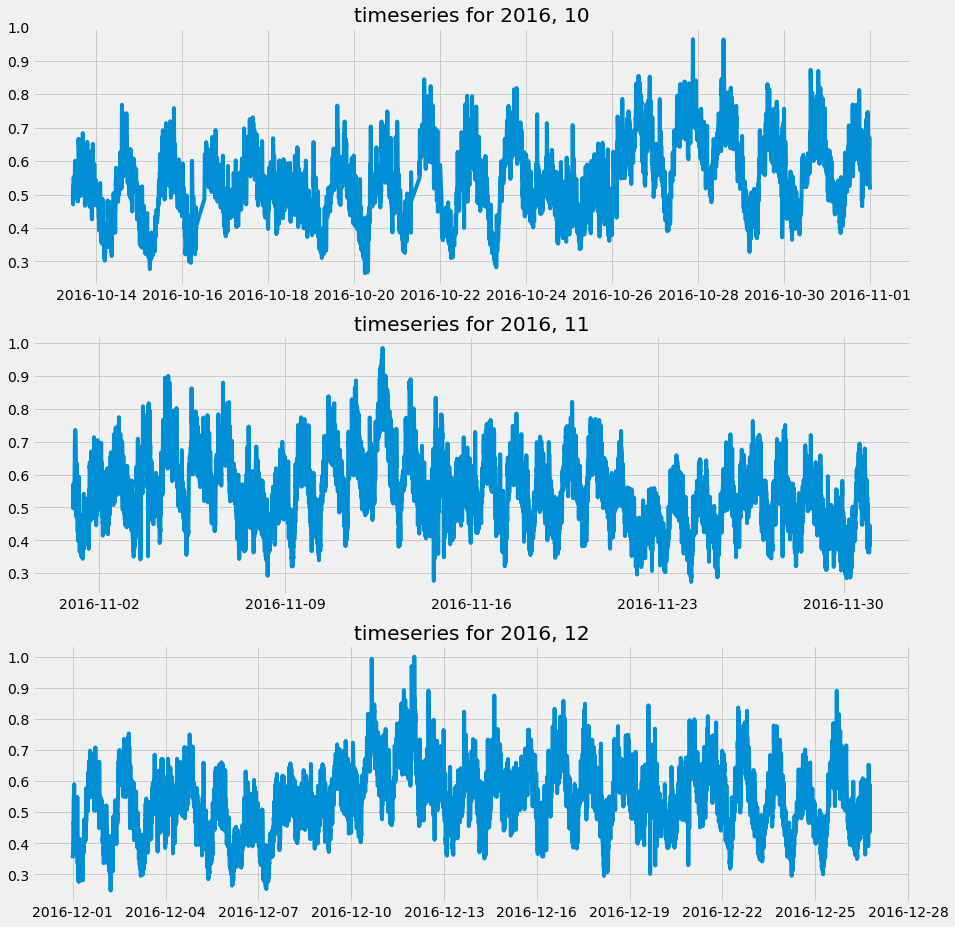

In [13]:
mp.plot_all_data(df,['power_all'])

In [14]:
y = y['power_all'].resample('D').mean()

In [15]:
y = y.fillna(y.bfill())

In [16]:
y.head()

t
2016-10-13    137799.977128
2016-10-14    125076.898143
2016-10-15    122078.433837
2016-10-16    124521.130656
2016-10-17    134942.000156
Freq: D, Name: power_all, dtype: float64

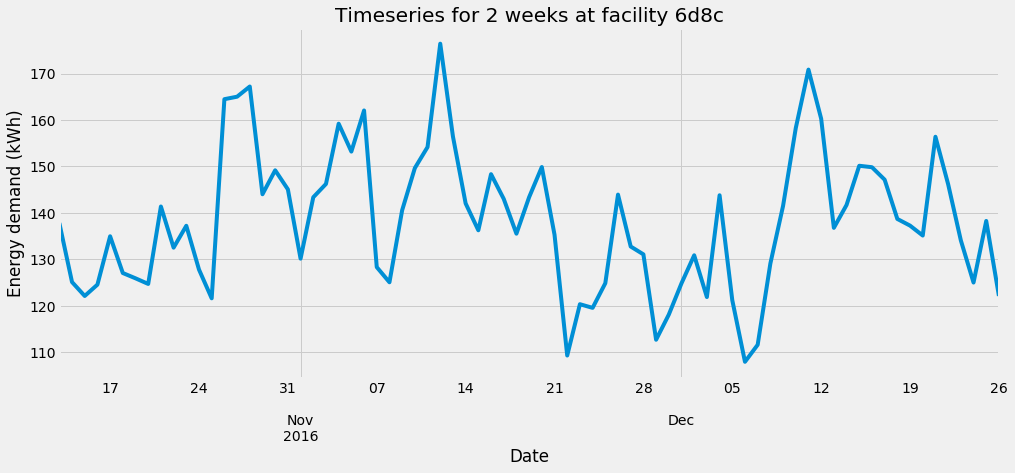

In [17]:
(y[-336:]/1000.).plot(figsize=(15, 6))
plt.title('Timeseries for 2 weeks at facility 6d8c')
plt.xlabel('Date')
plt.ylabel('Energy demand (kWh)')
plt.show()

# Trend Seasonal Residual Decomposition

In [18]:
python_decomposition = sm.tsa.seasonal_decompose(y)
def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

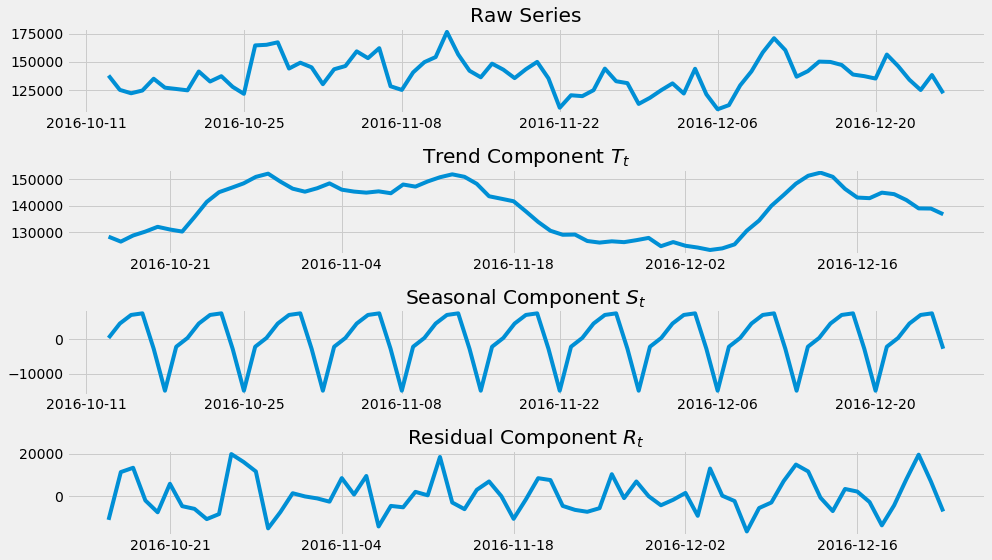

In [19]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, y, python_decomposition)
plt.tight_layout()
plt.show()

## Differencing

In [20]:
d = 24

In [21]:
def plot_series_and_difference(axs, series, title):
    diff = series.diff(d)
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

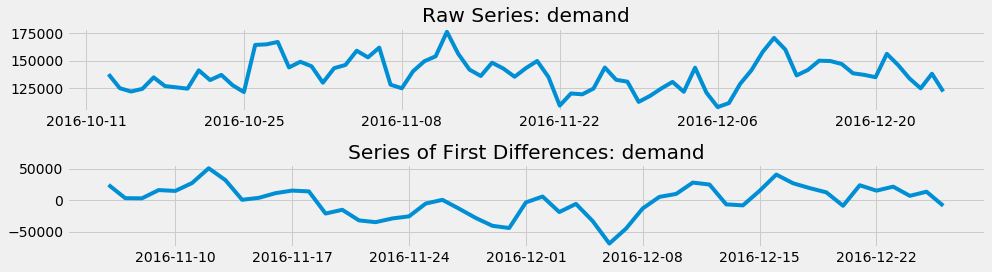

In [22]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, y, 'demand')
fig.tight_layout()
plt.show()

In [23]:
test = sm.tsa.stattools.adfuller(y)
print("ADF p-value for demand series: {0:2.2f}".format(test[1]))

ADF p-value for demand series: 0.00


In [24]:
test = sm.tsa.stattools.adfuller(y.diff(d)[d:])
print("ADF p-value for differenced demand series: {0:2.2f}".format(test[1]))

ADF p-value for differenced demand series: 0.02


## Baseline - previous

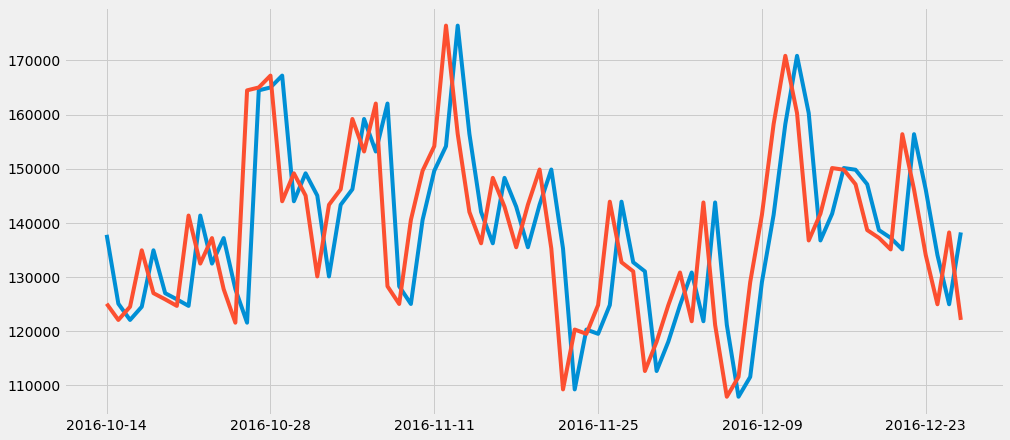

In [25]:
y_pred = y.shift()[1:]
plt.figure(figsize=(15,7))
plt.plot(y_pred)
plt.plot(y[1:])
plt.show()

In [26]:
# Compute the mean square error
rmse = np.sqrt(((y_pred - y[1:]) ** 2).mean())
print('The Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 13332.25


In [28]:
len(y)

75

## Auto correlation plots

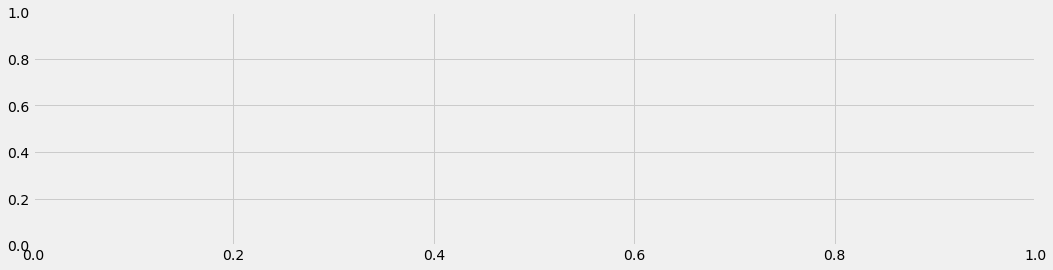

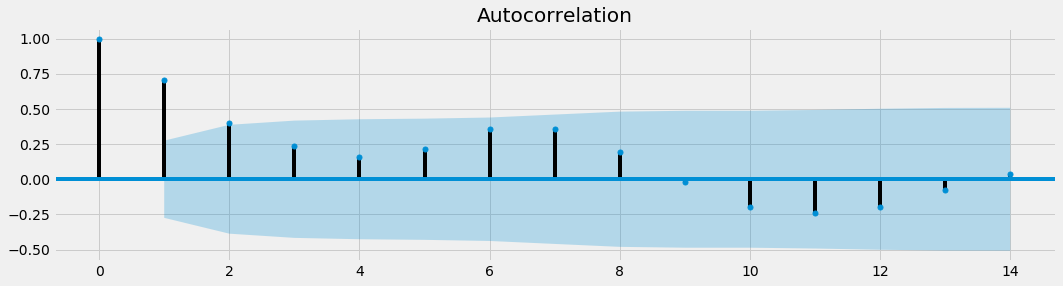

In [30]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(y.diff(d)[d:], lags=2*7, ax=ax)

plt.show()

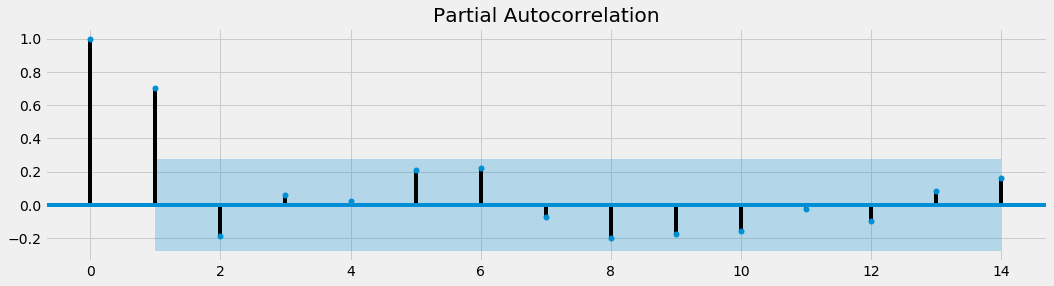

In [31]:
fig, ax = plt.subplots(1, figsize=(16, 4))
_ = sm.graphics.tsa.plot_pacf(y.diff(d)[d:], lags=2*7, ax=ax)
plt.show()

## Fitting SARIMA

In [32]:
length_data = len(y)
y_train = y[:int(length_data*(5./6))]
y_test = y[int(length_data*(5./6)):]

In [34]:
params = (1,0,1)
seasonal_params = (1,0,1,7)
mod = sm.tsa.statespace.SARIMAX(y_train,order=params,seasonal_order=seasonal_params,
                                enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print('ARIMA{}x{} - AIC:{}'.format(params, seasonal_params, results.aic))

ARIMA(1, 0, 1)x(1, 0, 1, 7) - AIC:1163.34500699


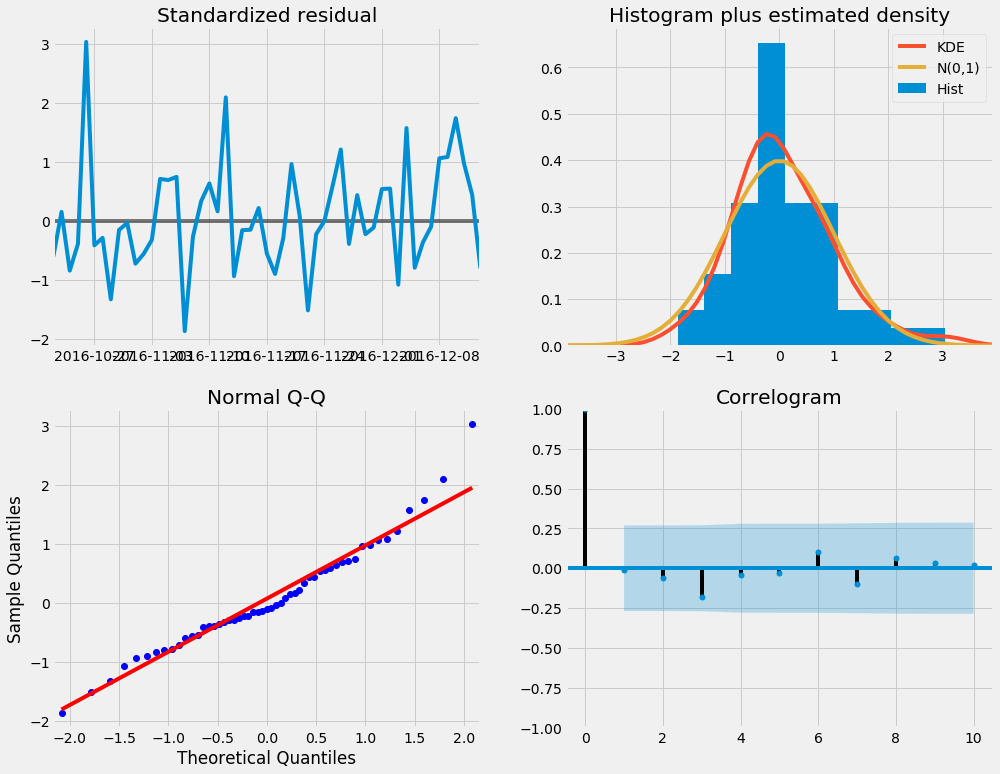

In [35]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

## Out of sample predictions
data trained on y_train, want to predict for y_test

In [36]:
y_train.index.max()

Timestamp('2016-12-13 00:00:00', freq='D')

In [37]:
results.get_prediction(start=y_train.index.max(), dynamic=False)

In [38]:
# one-step out-of sample forecast
forecast = results.forecast()
print forecast.values[0]
print y_test[0]

141842.366743
141688.281008


In [39]:
# one-step out of sample forecast
start_index = len(y_train)
end_index = len(y_train)
forecast = results.predict(start=start_index, end=end_index)
print y_test.index[0]
print forecast
print y_test[0]

2016-12-14 00:00:00
2016-12-14    141842.366743
Freq: D, dtype: float64
141688.281008


2016-12-14    141842.366743
2016-12-15    148919.499765
2016-12-16    153839.402790
2016-12-17    159553.295064
2016-12-18    165934.653441
2016-12-19    157414.125244
2016-12-20    143731.076197
Freq: D, dtype: float64
t
2016-12-14    141688.281008
2016-12-15    150128.286213
2016-12-16    149814.436007
2016-12-17    147128.241816
2016-12-18    138670.731107
2016-12-19    137232.682306
2016-12-20    135099.238469
Freq: D, Name: power_all, dtype: float64


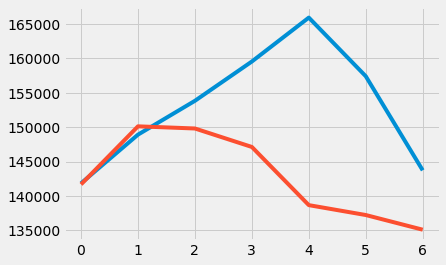

In [40]:
# multi-step out-of-sample forecast
forecast = results.forecast(steps=7)
# print y_test.index[:7]
print forecast
print y_test[:7]
plt.plot(forecast.values)
plt.plot(y_test[:7].values)
plt.show()

## In-sample constinuous predictions

In [41]:
pred = results.get_prediction(start=y_train[-48:].index[0], dynamic=False)
pred_ci = pred.conf_int()

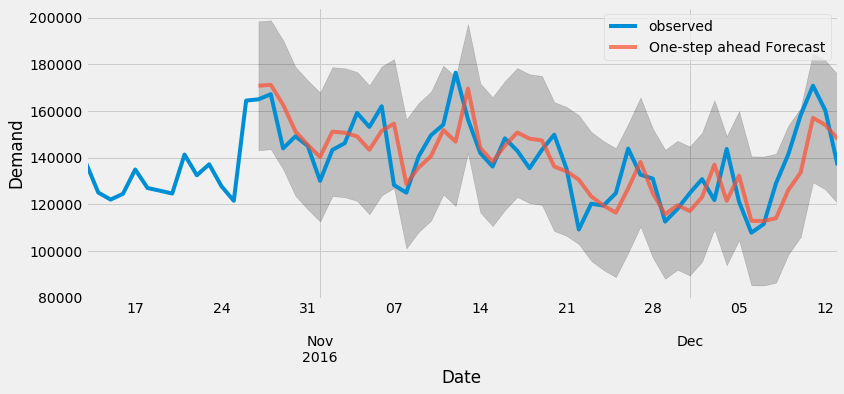

In [42]:
ax = y_train.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(12,5))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Demand')
plt.legend()

plt.show()

In [43]:
y_forecasted = pred.predicted_mean
y_truth = y_train[-48:]

# Compute the mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('The Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 11655.83


In [44]:
pred_dynamic = results.get_prediction(start=y_train[-48:].index[0], dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

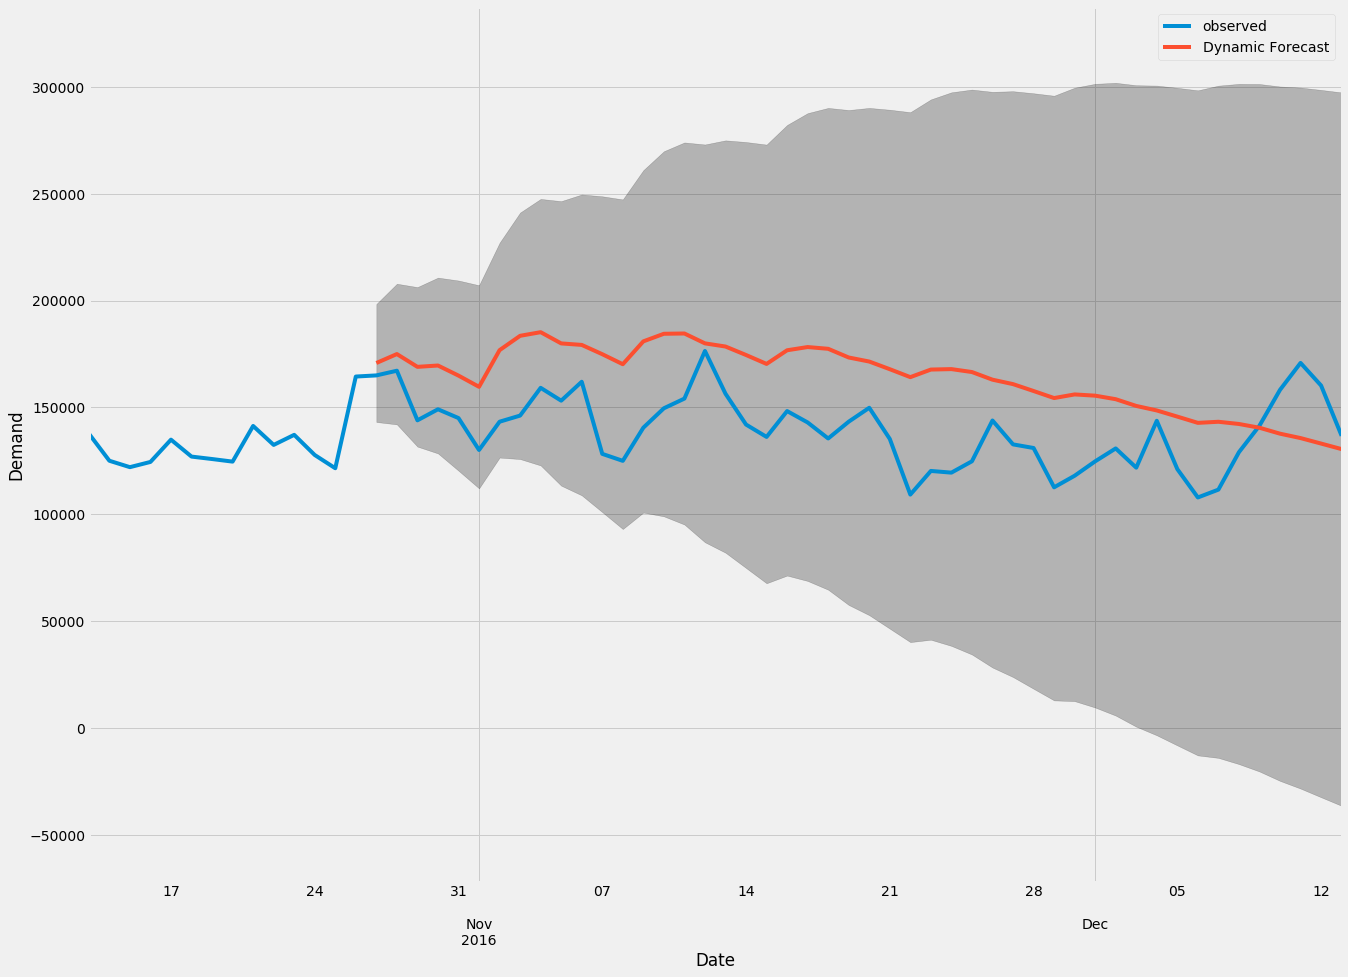

In [45]:
ax = y_train[-168:].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-06-15'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Demand')

plt.legend()
plt.show()

## Creating rolling RMSE eval with out of sample predictions:

In [46]:
def rolling_predictions_sarima(y,end,window,params):
    forecast = np.zeros(window)
    for i in xrange(window):
        y_temp = y[0:end+i] 
        model = sm.tsa.statespace.SARIMAX(y_temp,order=params[0],seasonal_order=params[1],
                                enforce_stationarity=False,enforce_invertibility=False)
        model = model.fit()
        forecast[i]= model.forecast(steps=1).values[0]
    return forecast

In [47]:
def cross_val_score(y, params, window=4, chunks=10):
    length = len(y)-window
    chunk_size = length/chunks
    rmses = []
    for i in xrange(chunks):
        end_index = (i+1)*chunk_size
        forecast = rolling_predictions_sarima(y,end_index,window, params)
        true = y[end_index:end_index+4].values
        rmse = np.sqrt(((true-forecast)**2).mean())
        rmses.append(rmse)
    return np.asarray(rmses)
    


In [49]:
params = (1,0,1)
seasonal_params = (1,0,1,7)
parameters = (params, seasonal_params)
rmses = cross_val_score(y,parameters,chunks=2)

In [50]:
rmses

array([ 16822.95565681,  11994.57900511])

## Fitting SARIMA with pre-diff

In [37]:
y_diff = y.diff(24)[(24):]
params = (3,0,1)
seasonal_params = (3,0,1,24)
mod = sm.tsa.statespace.SARIMAX(y_diff,order=params,seasonal_order=seasonal_params,
                                enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print('ARIMA{}x{}2016 - AIC:{}'.format(params, seasonal_params, results.aic))

ARIMA(3, 0, 1)x(3, 0, 1, 24)2016 - AIC:36344.4982453


In [38]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3930      0.155      9.012      0.000       1.090       1.696
ar.L2         -0.5558      0.123     -4.532      0.000      -0.796      -0.315
ar.L3          0.1190      0.049      2.450      0.014       0.024       0.214
ma.L1         -0.6022      0.156     -3.857      0.000      -0.908      -0.296
ar.S.L24       0.0446      0.048      0.932      0.351      -0.049       0.138
ar.S.L48      -0.0379      0.046     -0.819      0.413      -0.129       0.053
ar.S.L72      -0.0750      0.045     -1.665      0.096      -0.163       0.013
ma.S.L24      -0.8911      0.025    -35.931      0.000      -0.940      -0.843
sigma2      2.045e+08   2.22e-10    9.2e+17      0.000    2.04e+08    2.04e+08


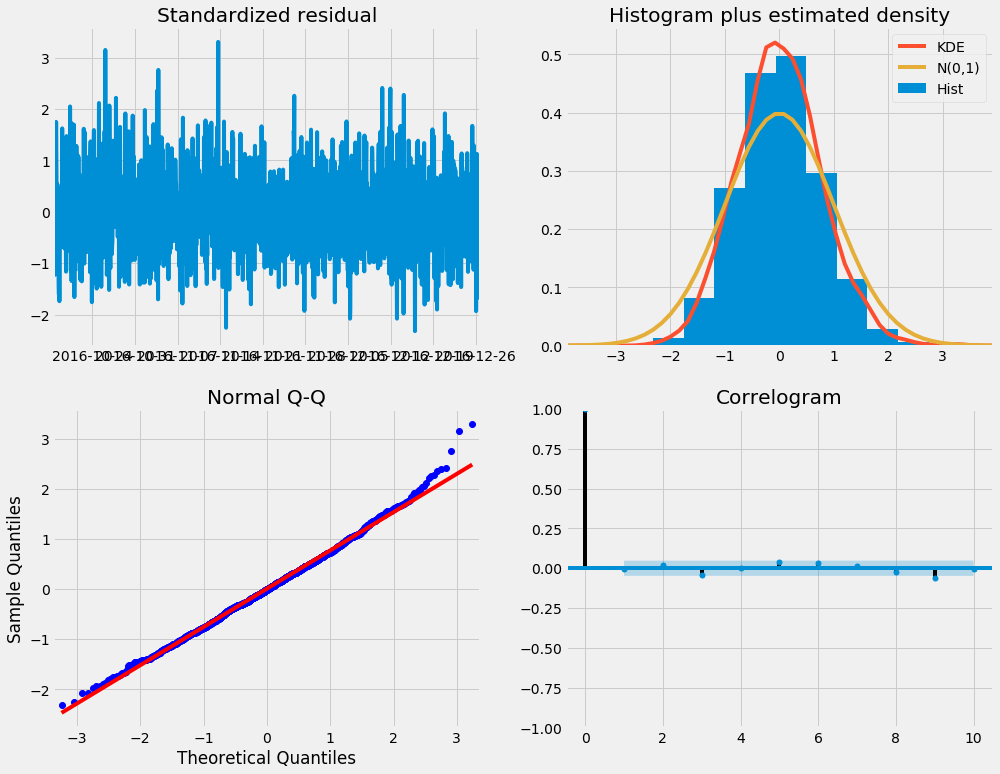

In [39]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [40]:
pred = results.get_prediction(start=y_diff[-24:].index[0], dynamic=False)
pred_ci = pred.conf_int()

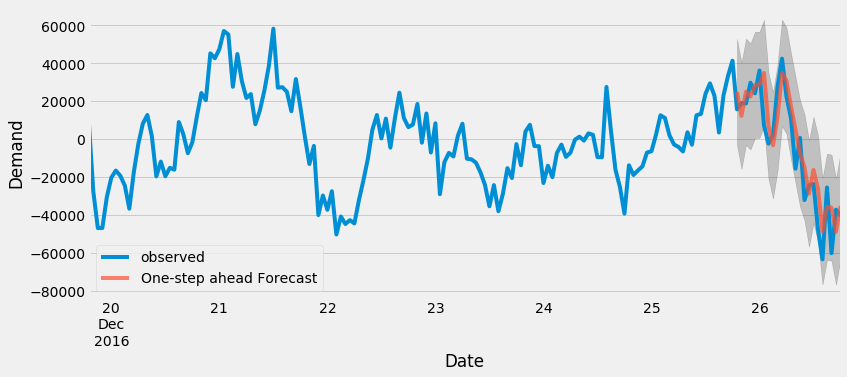

In [41]:

ax = y_diff[-168:].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(12,5))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Demand')
plt.legend()

plt.show()

In [42]:
y_forecasted = pred.predicted_mean
y_truth = y_diff[-24:]

# Compute the mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('The Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 12886.69


## Reconstruction

In [43]:
def one_ahead_reconstruction(y_pred, y_true):
    new_preds = np.zeros(len(y_pred))
    for i in range(len(new_preds)):
        date = y_pred.index[i]
        previous = y_true[date - pd.Timedelta(days=1)]
        new_preds[i] = y_pred.values[i] + previous
    return new_preds

y_forecasted = one_ahead_reconstruction(y_forecasted, y)

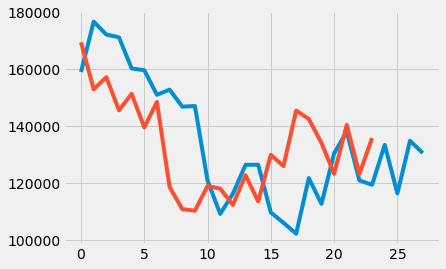

In [44]:
plt.plot(y[-28:].values)
plt.plot(y_forecasted)
plt.show()

In [45]:
pred_dynamic = results.get_prediction(start=y_diff[-24:].index[0], dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

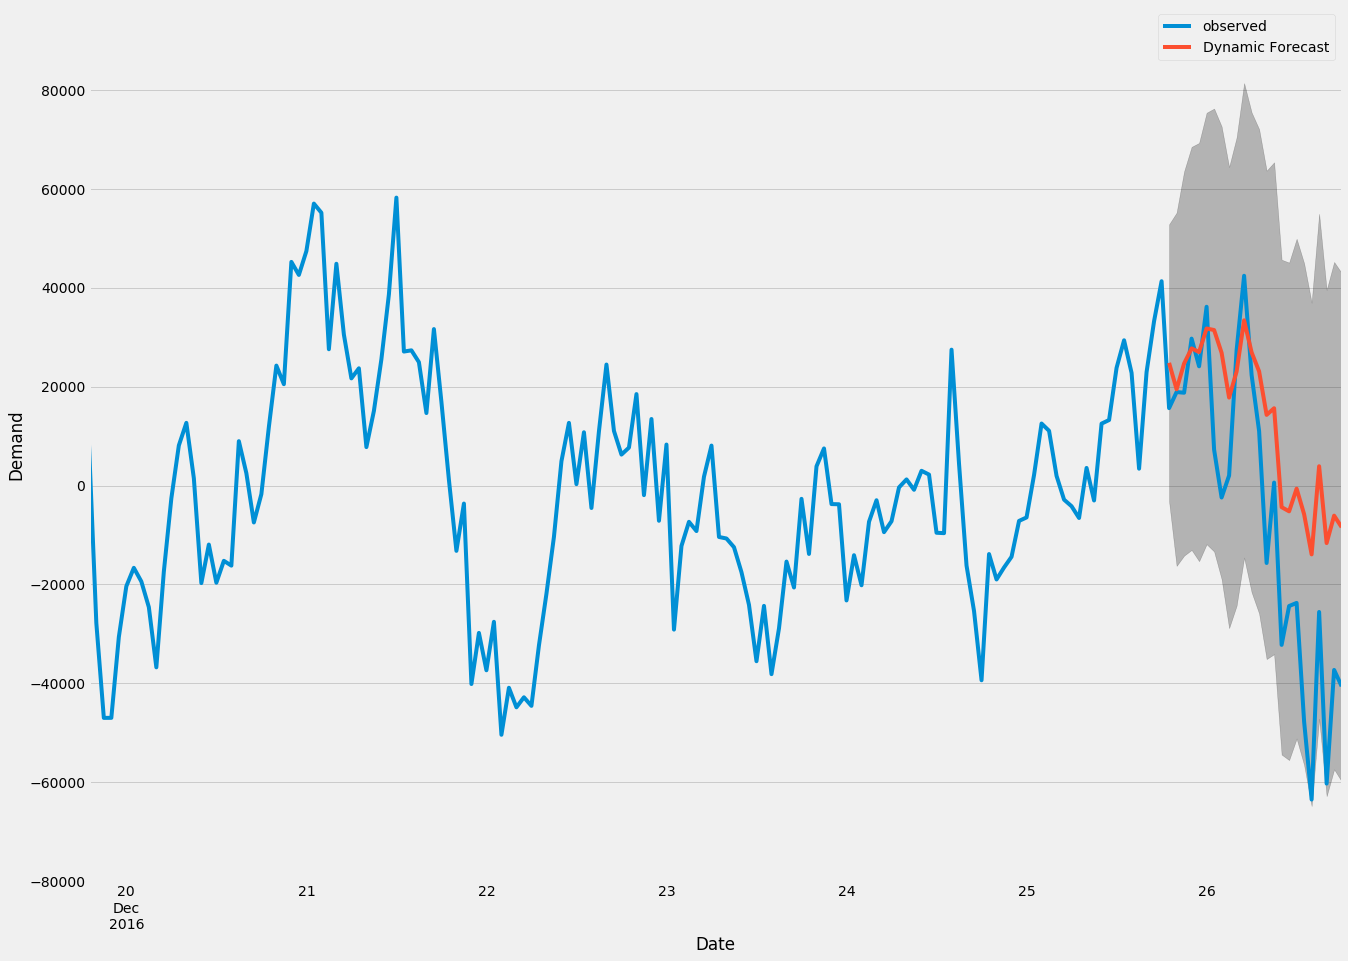

In [46]:
ax = y_diff[-168:].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-06-15'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Demand')

plt.legend()
plt.show()

### reconstructing the difference.... need a starting week to do so

It worked!!


In [47]:
preds = pred_dynamic.predicted_mean
new_preds = np.zeros(len(preds))
for i in range(len(preds)):
    date = preds.index[i]
#     diff1 = y[date - pd.Timedelta(days=7)]-y[date - pd.Timedelta(days=8)]
    diff2 = y[date - pd.Timedelta(days=1)]
    new_preds[i] = preds.values[i] +  diff2
# y[preds.index[0]-pd.Timedelta(days=1):]
y_true = y[preds.index[0]:].values

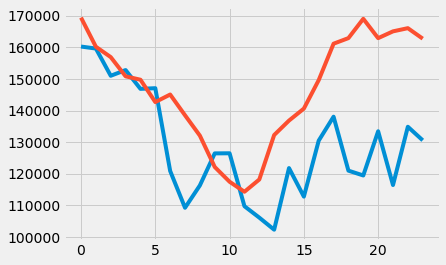

In [48]:
plt.plot(y_true[:24])
plt.plot(new_preds[:24])
plt.show()

## Check that it is working correctly

In [49]:
x = y.diff(24).diff(168)[192:]
new_preds = np.zeros(len(x))
for i in range(len(x)-1):
    date = x.index[i]
    diff1 = y[date - pd.Timedelta(days=7)]-y[date - pd.Timedelta(days=8)]
    diff2 = y[date - pd.Timedelta(days=1)]
    new_preds[i] = x.values[i] + diff1 + diff2
y_true = y[192:].values

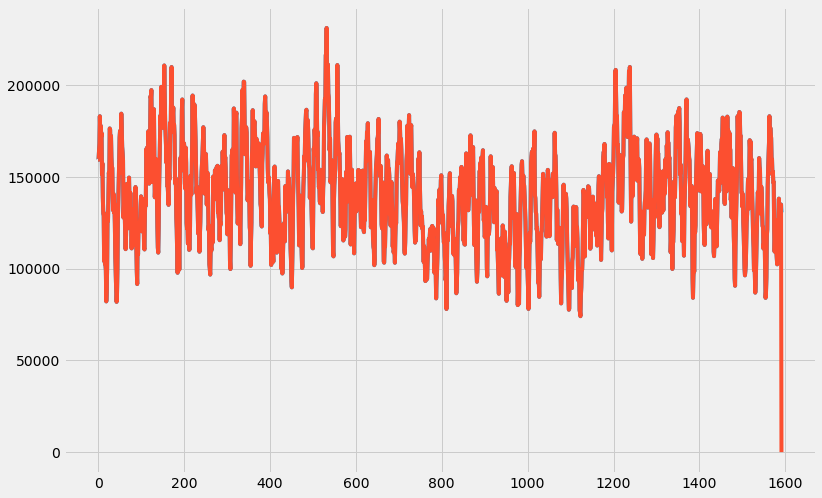

In [50]:
plt.figure(figsize=(12,8))
plt.plot(y_true)
plt.plot(new_preds)
plt.show()

## Create Function

In [51]:
def reconstruct_day_week(preds, y_true):
    new_preds = np.zeros(len(preds))
    for i in range(len(new_preds)):
        date = preds.index[i]
        diff1 = y_true[date - pd.Timedelta(days=7)]-y_true[date - pd.Timedelta(days=8)]
        diff2 = y_true[date - pd.Timedelta(days=1)]
        new_preds[i] = preds.values[i] + diff1 + diff2
    return new_preds

def reconstruct_day(preds, y_true):
    new_preds = np.zeros(len(preds))
    for i in range(len(new_preds)):
        date = preds.index[i]
        diff1 = 0
        diff2 = y_true[date - pd.Timedelta(days=1)]
        new_preds[i] = preds.values[i] + diff1 + diff2
    return new_preds

In [52]:
preds = pred_dynamic.predicted_mean
new_preds = np.zeros(len(preds))
new_p = reconstruct_day(preds, y)

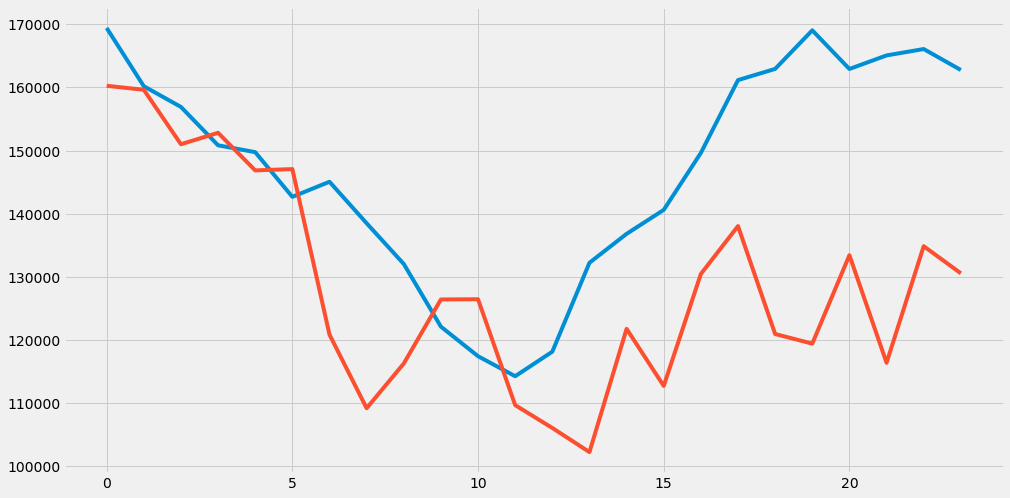

In [53]:
plt.figure(figsize=(15,8))
plt.plot(new_p[:24])
plt.plot(y[preds.index[0]:].values[:24])
plt.show()